# 用聚类分析处理无标签数据

主要涵盖以下几个方面的概念，这将有助于将数据组成有意义的结构
* 使用流行的k-均值算法寻找相似中心
* 采用自下而上的方法构建层次形聚类树
* 使用基于密度的聚类方法识别任意形状的物体

## 用k-均值进行相似性分组

### scikit-learn的k-均值聚类

k-均值算法属于基于原型聚类的范畴。

基于原型的聚类方法意味着每个集群代表一个原型，可以是有类似连续性特征点的重心，或者是在分类特征最具代表性或最频繁出现的中心。k-均值方法非常擅长识别球形集群，其缺点是必须指定集群数k。所以它是个先验方法。如果k值选择不当会导致聚类性能不良。__肘__法和__轮廓图__是评估聚类质量以确定最佳聚类集群数k的有效技术。

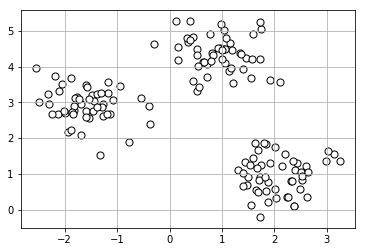

In [5]:
%matplotlib inline
from sklearn.datasets import make_blobs
X,y = make_blobs(n_samples=150,
                 n_features=2,
                 centers=3,
                 cluster_std=0.5,
                 shuffle=True,
                 random_state=0)
import matplotlib.pyplot as plt
plt.scatter(X[:,0],
            X[:,1],
            c='white',
            marker='o',
            edgecolor='black',
            s=50)
plt.grid()
plt.show()

前面刚创建的数据集包括150个随机生成的点，大致有三个高密度区域，可以通过二维散点图实现可视化。

实际的聚类应用并没有任何关于标定样本的真实分类信息，否则它将属于有监督学习的范畴。因此目标是根据特征的相似性对样本进行分组，这可以通过以下四个步骤所总结出的k-均值算法来实现：
1. 随即从样本中挑选k个重心作为初始聚类中心。
2. 将每个样本分配到最近的重心$\mu^{(j)},j\in \{1,\dots,k\}$。
3. 把重心移到已分配样本的中心。
4. 重复步骤2和3，直到集群赋值不再改变，或者达到用户定义的容限或最大迭代数。

下一个问题是如何度量对象之间的相似性？可以把相似性定义为距离的反义，具有连续特征的聚类样本，其常用距离为m维空间中x和y之间的欧氏距离的平方：
$$d(x,y)^2=\sum_{j=1}^m(x_j-y_j)^2=||\textbf x-\textbf y||^2_2$$

注意，在前面的方程中，指数j是指样本点__x和y__的第j维（特征列）。本节其余部分将用下标i和j分别代表样本索引和聚类索引。

基于欧几里得距离度量，可以把k-均值算法描述为一种简单的优化问题，是一种最小化群内误差平方和（SSE）的迭代方法，有时也被称为__群属性__：
$$SSE=\sum_{i=1}^n\sum_{j=1}^kw^{(i,j)}||\textbf x^{(i)}-\mu^{(i)}||^2_2$$

这里$\mu^{(j)}$为集群j的代表点（重心），如果样本$\textbf x^{(i)}$在集群j中，$w^{(i,j)}=0$否则$w^{(i,j)}=1$

现在已经理解了简单点的k-均值算法的工作原理，我们将用__KMeans__类scikit-learn cluster模块将其应用到样本数据：

In [7]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3,
            init='random',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

k-均值的问题是一个或多个集群可能为空。如果一个集群为空，该算法将搜索与集群中心相距最远的样本，然后将中心重新分配为最远点。

在预测了聚类标签y_km和讨论了一些k-均值算法的挑战后，把k-均值在数据集中发现的集群以及聚类中心用图表示出来。这些数据存储在拟合对象KMeans的属性cluster_centers_中

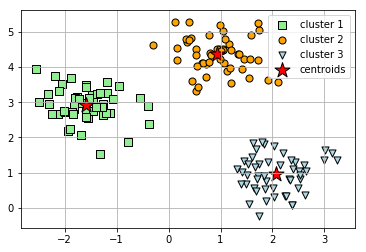

In [8]:
plt.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            s=50, c='lightgreen',
            marker='s',edgecolor='black',
            label='cluster 1')
plt.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            s=50,c='orange',
            marker='o',edgecolor='black',
            label='cluster 2')
plt.scatter(X[y_km == 2, 0],
            X[y_km == 2, 1],
            s=50,c='lightblue',
            marker='v',edgecolor='black',
            label='cluster 3')
plt.scatter(km.cluster_centers_[:,0],
            km.cluster_centers_[:,1],
            s=250,marker='*',
            c='red',edgecolor='black',
            label='centroids')
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

但必须指出k-均值的另一个缺点：必须在无推理的前提下指定集群的数目k。在实际应用中，选择的集群数目可能并不总是那么明显。特别是在处理无法可视化的高维数据集时。

k-均值的其他特性时假设每个集群中至少有一个成员，集群不重叠而且不分层。

## k-均值++——更聪明地设置初始聚类中心的方法

经典k-均值算法用随机数种子设置初始值中心，有时如果初始聚类中心选择不当会导致聚类不良或收敛缓慢。解决这个问题地一种方法是在数据集上多次运行k-均值算法，并根据SSE选择性能最佳地模型。

另一个策略是通过k-均值++算法，将初始中心彼此地距离设置的足够远，带来比经典k-均值更好和更一致的结果。

k-均值++的初始化过程如下：
1. 初始化空集合M来存储选择的k个重心。
2. 从输入样本中随机选择第一个重心$\mu^{(j)}$然后加入M。
3. 找出不在M中的每个样本$\textbf x^{(i)}$与M中每个点的最小距离的平方$d(\textbf x^{(i)},\textbf M)^2$。
4. 随机选择下一个重心$\mu^{(p)}$，计算加权概率分布$\frac{d(\mu ^{(p)},\textbf M)^2}{\sum_id(\textbf x^{(i)},\textbf M)^2}$。
5. 重复步骤2和3直至选中k个重心。
6. 继续进行经典k-均值算法。

要用scikit-learn的KMeans对象的k-均值++，只需要把k-均值++的参数init设置成'k-means++'。事实上，'k-means++'是形式参数init的默认实际参数，在实践中强烈推荐该选择。

## 硬聚类和软聚类

__硬聚类__描绘了一类算法，把数据集中的每一个样本分配到一个集群。__软聚类__方法则将一个样本分配给一个或多个集群。常见的软聚类例子是模糊C-均值算法（FCM）

FCM与k-均值程序非常相似，用集群中的每一个点的概率替换硬集群分配。在k-均值中，可以用二进制的稀疏向量表示样本x的集群成员：
$$\begin{bmatrix} \mu^{(1)} \to 0 \\ \mu^{(2)} \to 0 \\ \mu^{(3)} \to 0\end{bmatrix}$$

值为1的索引位置指示集群重心$\mu^{(j)}$赋予样本的值。与之相反，可以把FCM的成员向量表示如下：
$$\begin{bmatrix} \mu^{(1)} \to 0.10 \\ \mu^{(2)} \to 0.85 \\ \mu^{(3)} \to 0.05 \end{bmatrix}$$

每个成员的取值范围为[0,1]，代表各个成员相对于集群重心的概率。给定样本成员概率之和等于1。

FCM算法总结为四个关键步骤：
1. 指定k重心的数量然后随机为每个重心分配集群成员。
2. 计算集群的中心$\mu^{(i)}$，$j\in\{1,\dots,k\}$
3. 更新每个点的集群成员。
4. 重复步骤2和3直到成员系数不再变化，或达到用户定义的容限或最大迭代数。